In [1]:
import datetime
import sys
from pathlib import Path
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from configuredEstimator import confRegressorEstimator

tf.logging.set_verbosity(tf.logging.INFO)

sys.path.append("/jup/projects/mtgtools2/")  # ensure we find the MTG libraries
import pymtg.fci.esl.training_data as esl
import pymtg

MNT_DIR = Path("/scratch/andreu/")
RETINAS_JSON = Path(pymtg.__file__).parent.parent / "test/FCI_ESL/pyesl/config/retinas.json"
ESL_PATH = MNT_DIR / "ESL/nc/output/20170615T152646/ch123/"
FCI_PATH = MNT_DIR / "ESL/nc/swaths/"

def collapse_scene(scene, step=1):
    col_scene = scene[0]
    for s in scene[1:]:
        col_scene = np.insert(col_scene, -step, s.transpose()[-step], axis=1)  # create single input scene.
    return col_scene

def plot_scene(scene):
    plt.imshow(collapse_scene(scene))
    plt.title('Input scene')
    plt.show()

def plot_esl(esl):
    plt.imshow(esl.T)
    plt.title('ESL')
    plt.show()
    
def get_model_name(name='Unnamed_conf_model'):
    d = datetime.datetime.now()
    return "{}_{}".format(name, d.strftime("%Y%m%dT%H%M%S"))
                          
def get_model_dir(model_dir, **kwargs):
    return "{}/{}".format(model_dir, get_model_name(**kwargs))
                          
def input_fn(size, train_or_test='train', collapsed=False, num_batches=1, mode=tf.estimator.ModeKeys.TRAIN, plot_data=False):
    """
    Input function that serves data to the estimator.
    If not collapsed it will return x={features:(size*num_batches, 129, 186), y=(size*num_batches, 113).
    If collapsed, it will return x={features:(num_batches, 129, 186+size)}, y=(num_batches, 113xsize)
    The argument train_or_test should be set to train for the moment, as test is not validated.
    """
    print("Calling input_fn with collapsed={}, num_batches={}, size={}".format(collapsed, num_batches, size))
    files = esl.prepare_training_data(FCI_PATH, ESL_PATH, 0, str(RETINAS_JSON))
    out_batch = list(files[train_or_test].batches("ch123", size, 20000, num_batches=num_batches))  # use always 'train', 'test' is not validated
    if collapsed:
        features = np.array([collapse_scene(out_batch[i][0]) for i in range(num_batches)])
        labels = np.array([out_batch[i][1].flatten() for i in range(num_batches)])
    else:
        features = np.concatenate([out_batch[i][0] for i in range(len(out_batch))], axis=0)  # flatten into a (num_batches*size, 129, 113)
        labels = np.concatenate([out_batch[i][1] for i in range(len(out_batch))], axis=0)
    if plot_data:  # for validation purposes during prediction, will plot only the first image
        if collapsed:
            for f in features:
                plt.imshow(f)
                plt.show()
            for l in labels:
                plt.imshow(l.reshape(out_batch[0][1].shape))
                plt.show()
        else:
            plot_scene(features)
            plot_esl(labels)    
    dataset = tf.data.Dataset.from_tensors(({'x': features}, labels))
    return dataset

Calling input_fn with collapsed=False, num_batches=20, size=100


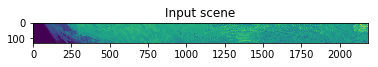

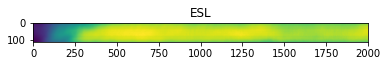

<TensorDataset shapes: ({x: (2000, 129, 186)}, (2000, 113)), types: ({x: tf.float64}, tf.float64)>

In [2]:
dataset = input_fn(100, num_batches=20, plot_data=True, collapsed=False)
dataset

In [3]:
from functools import partial

SIZE = 50
TRAIN_STEPS=10
TEST_STEPS=1
MODEL = 'CONV1.yml'
NUM_BATCHES = 1
COLLAPSED = False

def get_config_name():
    coll = 'collapsed' if COLLAPSED else 'not_collapsed'
    return MODEL + '_' + coll + '_size_' + str(SIZE) + '_batches_' + str(NUM_BATCHES) + '_train_steps_' + str(TRAIN_STEPS)

# config
name = get_model_name()
run_config= tf.estimator.RunConfig(model_dir=get_model_dir("/scratch/tensorboard", name=get_config_name()),
                                    save_checkpoints_steps=10,
                                    keep_checkpoint_max = 3)
                        
# create the estimator
esl_regressor = confRegressorEstimator(MODEL, config=run_config)                                    

INFO:tensorflow:Using config: {'_model_dir': '/scratch/tensorboard/CONV1.yml_not_collapsed_size_50_batches_1_train_steps_10_20180822T130913', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe0829de780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [4]:
# this training process will train with TRAIN_STEPS different images and it will iterate N_ITER times on each
# it will only IO every time it enters train()
N_ITER = 1000
for i in range(TRAIN_STEPS):
    esl_regressor.train(input_fn=partial(input_fn, size=SIZE, num_batches=NUM_BATCHES, collapsed=COLLAPSED), max_steps=None, steps=N_ITER)

Calling input_fn with collapsed=False, num_batches=1, size=50
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /scratch/tensorboard/CONV1.yml_not_collapsed_size_50_batches_1_train_steps_10_20180822T130913/model.ckpt.
INFO:tensorflow:loss = 0.00014584028, step = 1
INFO:tensorflow:Loss for final step: 0.00014584028.
Calling input_fn with collapsed=False, num_batches=1, size=50
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /scratch/tensorboard/CONV1.yml_not_collapsed_size_50_batches_1_train_steps_10_20180822T130913/model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
IN

In [5]:
# single evaluation
esl_regressor.evaluate(input_fn=partial(input_fn, size=SIZE, num_batches=1, collapsed=COLLAPSED, plot_data=False), steps=TEST_STEPS)

Calling input_fn with collapsed=False, num_batches=1, size=50
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-22-13:12:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /scratch/tensorboard/CONV1.yml_not_collapsed_size_50_batches_1_train_steps_10_20180822T130913/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-08-22-13:12:06
INFO:tensorflow:Saving dict for global step 10: RMS = 0.0049587116, accuracy = 0.0, global_step = 10, loss = 2.458882e-05, mean_absolute_error = 0.004609111


{'RMS': 0.0049587116,
 'accuracy': 0.0,
 'loss': 2.458882e-05,
 'mean_absolute_error': 0.004609111,
 'global_step': 10}

Calling input_fn with collapsed=False, num_batches=1, size=50


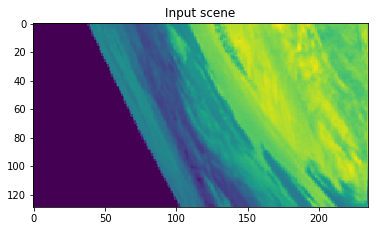

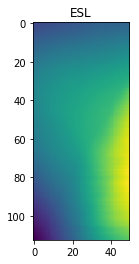

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /scratch/tensorboard/CONV1.yml_not_collapsed_size_50_batches_1_train_steps_10_20180822T130913/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


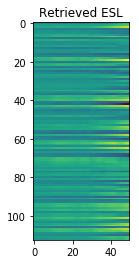

In [6]:
foo = esl_regressor.predict(input_fn=partial(input_fn, size=SIZE, num_batches=1, collapsed=COLLAPSED, plot_data=True))
pred_esl = np.array([p['predictions'] for p in foo])

plt.imshow(pred_esl.reshape((SIZE, 113)).T)
plt.title('Retrieved ESL')
plt.show()

In [7]:
CONV1.yml_collapsed_size_200_batches_10_train_steps_100_20180814T122114



NameError: name 'CONV1' is not defined